Using device: mps
Preparing data for 5000 VMs...
Data prepared: 1500000 samples.
Starting SADE optimization for the predictor...
Generation 1, Best RMSE: 0.167935
Generation 2, Best RMSE: 0.167935
Generation 3, Best RMSE: 0.144039
Generation 4, Best RMSE: 0.144039
Generation 5, Best RMSE: 0.144039
Generation 6, Best RMSE: 0.135785
Generation 7, Best RMSE: 0.135785
Generation 8, Best RMSE: 0.135785
Generation 9, Best RMSE: 0.135785
Generation 10, Best RMSE: 0.135785
Generation 11, Best RMSE: 0.135524
Generation 12, Best RMSE: 0.135524
Generation 13, Best RMSE: 0.135524
Generation 14, Best RMSE: 0.135166
Generation 15, Best RMSE: 0.135166
Generation 16, Best RMSE: 0.133606
Generation 17, Best RMSE: 0.133606
Generation 18, Best RMSE: 0.133264
Generation 19, Best RMSE: 0.133264
Generation 20, Best RMSE: 0.133264
Generation 21, Best RMSE: 0.131490
Generation 22, Best RMSE: 0.130654
Generation 23, Best RMSE: 0.130434
Generation 24, Best RMSE: 0.130434
Generation 25, Best RMSE: 0.129050
Gener

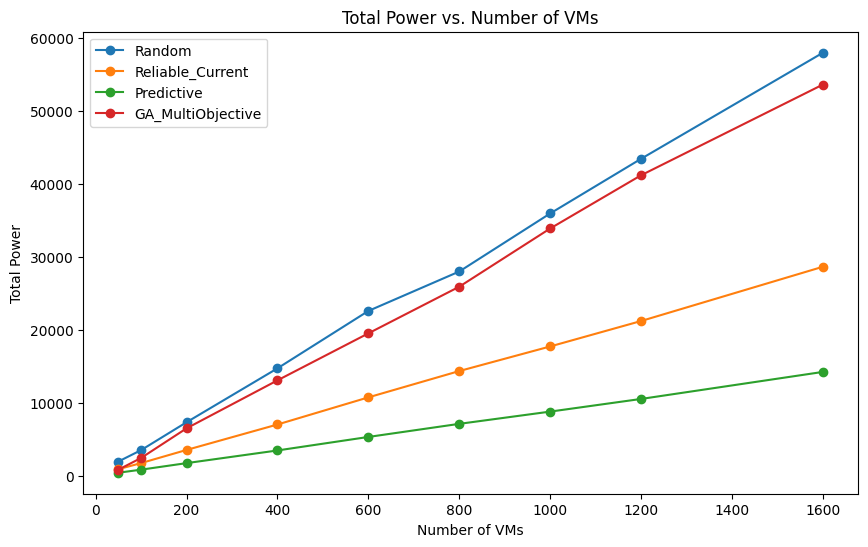

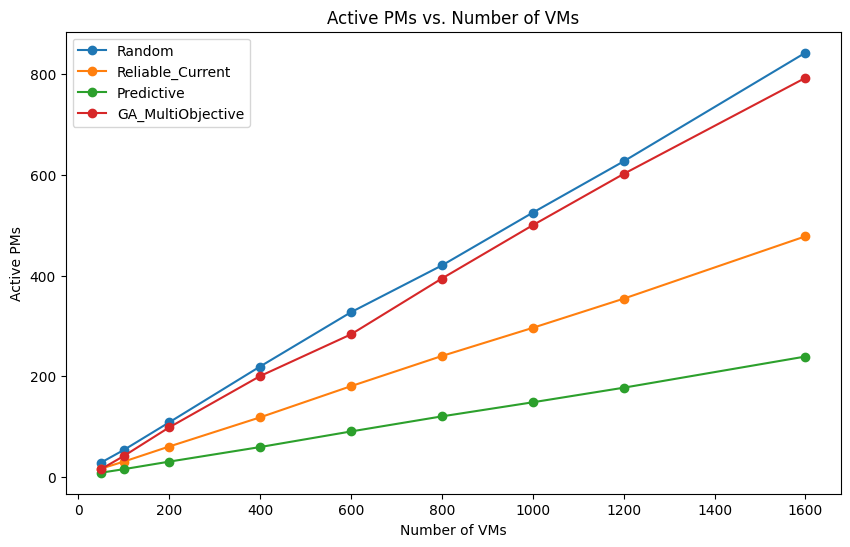

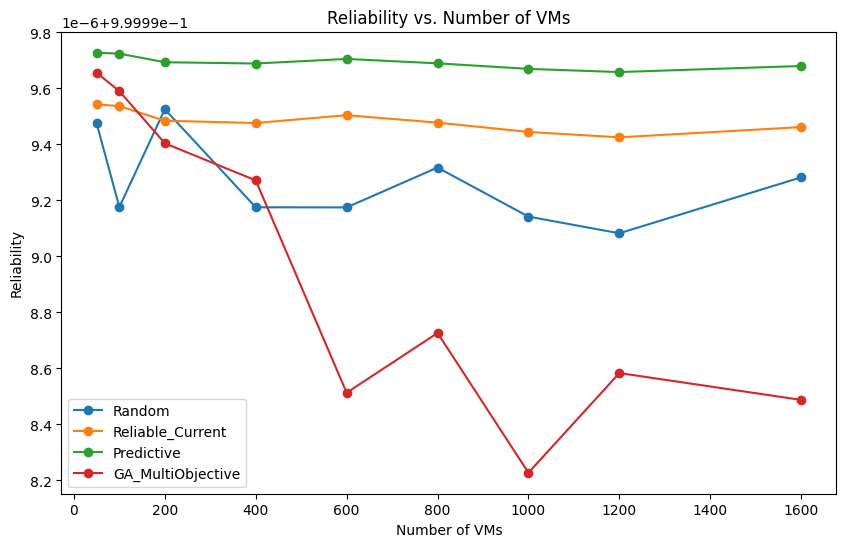

D_min = 0.0
D_max = 129.65324


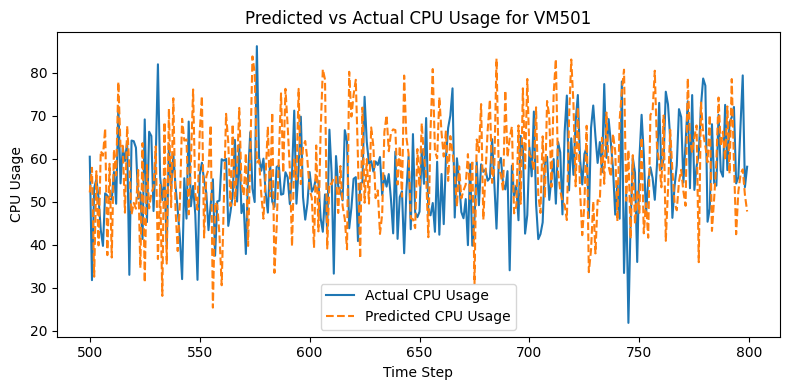

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import math
import copy
import random
import time

# Set device (for Apple Silicon, use MPS if available)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

# %%
"""
End-to-End Simulation using Simulated Data and an Actual SADE Optimizer for Neural Network Training

This script:
  1. Creates synthetic data (with increased noise and occasional spikes to simulate turbulence).
  2. Creates Physical Machines (PMs) and Virtual Machines (VMs) with historical CPU usage.
  3. Trains a feed-forward neural network predictor (to forecast next CPU usage) 
     using a simplified Self-Adaptive Differential Evolution (SADE) optimizer.
  4. Implements multiple allocation strategies:
       - Random Allocation
       - Reliable Allocation (using current demand)
       - Predictive Allocation (using NN predictions)
       - GA-based Multi-Objective Allocation
  5. Computes metrics (total power, active PM count, system reliability) and produces charts/tables.
"""

# %%
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# %%
# ------------------------------
# Define Classes for PM and VM
# ------------------------------
class VirtualMachine:
    def __init__(self, id, cpu_demand, ram_demand, job_length, history, history_mem=None):
        self.id = id
        self.cpu_demand = cpu_demand      # current CPU demand (units)
        self.ram_demand = ram_demand      # current RAM demand (GB)
        self.job_length = job_length      # job length (for reliability calculation)
        self.history = history            # historical CPU usage (list of floats)
        self.predicted_cpu = None         # predicted future CPU usage (to be computed)
        self.allocated_pm = None          # PM id after allocation
        self.history_mem = history_mem if history_mem else []

# %%
class PhysicalMachine:
    def __init__(self, id, cpu_capacity, ram_capacity, power_max, power_idle, hazard_rate, reliability_score):
        self.id = id
        self.total_cpu = cpu_capacity
        self.avail_cpu = cpu_capacity
        self.total_ram = ram_capacity
        self.avail_ram = ram_capacity
        self.power_max = power_max
        self.power_idle = power_idle
        self.hazard_rate = hazard_rate  # This is used as lambda_max (1/MTBF)
        self.reliability_score = reliability_score  # (not used directly in our reliability calculation)
        self.allocated_vms = []  # list of VM ids

    def reset(self):
        self.avail_cpu = self.total_cpu
        self.avail_ram = self.total_ram
        self.allocated_vms = []

    def current_utilization(self):
        used_cpu = self.total_cpu - self.avail_cpu
        return used_cpu / self.total_cpu if self.total_cpu > 0 else 0

    def compute_power(self):
        # Power = P_idle + (P_max - P_idle)*utilization.
        utilization = self.current_utilization()
        return self.power_idle + (self.power_max - self.power_idle) * utilization

#########################################
# Synthetic Data Generation (with turbulence)
#########################################
def create_synthetic_vms(num_vms=20, history_length=1000, scale_factor=50):
    """
    Create synthetic VMs with noisy and turbulent CPU usage history.
    """
    def generate_synthetic_history(length=10, base=50, noise_level=15):
        t = np.arange(length)
        history = base + 10 * np.sin(2 * np.pi * t / length) + np.random.randn(length) * noise_level
        spikes = np.random.choice([0, 20 * np.random.rand()], size=length, p=[0.95, 0.05])
        history = history + spikes
        return np.clip(history, 0, None).tolist()
    
    vms = []
    for i in range(num_vms):
        history = generate_synthetic_history(length=history_length, base=random.uniform(30, 70), noise_level=10)
        cpu_demand = int(history[-1] * scale_factor)
        ram_demand = random.choice([1, 2, 4])
        job_length = random.uniform(2, 5)
        vms.append(VirtualMachine(id=f"VM{i+1}", cpu_demand=cpu_demand, ram_demand=ram_demand,
                                  job_length=job_length, history=history))
    return vms

#########################################
# Physical Machines (unchanged except MTBF values remain low)
#########################################
def create_multiple_pms(num_vms):
    num_pms = max(1, int(np.ceil(num_vms / 1.67)))
    pm_list = []
    pm_types = ["S1", "S2", "S3"]
    probabilities = [0.4, 0.3, 0.3]
    MTBF_S1 = 10  
    MTBF_S2 = 12  
    MTBF_S3 = 15  
    for i in range(num_pms):
        pm_type = random.choices(pm_types, weights=probabilities, k=1)[0]
        if pm_type == "S1":
            cpu_capacity = 5320
            ram_capacity = 4
            power_max = 135
            power_idle = 93.7
            hazard_rate = 1.0 / MTBF_S1  
            reliability_score = 0.80
        elif pm_type == "S2":
            cpu_capacity = 12268
            ram_capacity = 8
            power_max = 113
            power_idle = 42.3
            hazard_rate = 1.0 / MTBF_S2
            reliability_score = 0.70
        elif pm_type == "S3":
            cpu_capacity = 36804
            ram_capacity = 16
            power_max = 222
            power_idle = 58.4
            hazard_rate = 1.0 / MTBF_S3
            reliability_score = 0.90
        pm_list.append(PhysicalMachine(id=f"PM{i+1}", cpu_capacity=cpu_capacity, ram_capacity=ram_capacity,
                                       power_max=power_max, power_idle=power_idle,
                                       hazard_rate=hazard_rate, reliability_score=reliability_score))
        # print(f"PM{i+1}: Type={pm_type}, CPU={cpu_capacity}, RAM={ram_capacity}, Power Max={power_max}, Power Idle={power_idle}, "
        #       f"MTBF={1/hazard_rate}, Reliability={reliability_score}")
    print(f"Total PMs created: {len(pm_list)}")
    return pm_list

#########################################
# Neural Network Predictor with increased Dropout
#########################################
class UsagePredictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, dropout_prob=0.1):
        super(UsagePredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out = self.fc1(x)
        x = self.relu(x)
        out = self.dropout(out)
        out = self.fc2(out)
        # out = self.sigmoid(out)
        return out

#########################################
# Helpers for SADE (unchanged)
#########################################
def get_flat_params(model):
    params = []
    for p in model.parameters():
        params.append(p.detach().cpu().numpy().flatten())
    return np.concatenate(params)

def set_flat_params(model, flat_vector):
    pointer = 0
    with torch.no_grad():
        for p in model.parameters():
            numel = p.numel()
            new_vals = flat_vector[pointer:pointer+numel]
            new_vals = new_vals.reshape(p.shape)
            p.copy_(torch.from_numpy(new_vals).type_as(p))
            pointer += numel

def fitness_function(model, X, y):
    model.eval()
    with torch.no_grad():
        outputs = model(X)
    loss = np.sqrt(((outputs.cpu().numpy() - y.cpu().numpy())**2).mean())
    return loss

def sade_optimizer(model, X, y, population_size=30, generations=50, F=0.5, CR=0.9, mutation_learning_period=10):
    base = get_flat_params(model)
    D = base.shape[0]
    population = [base + np.random.randn(D)*0.1 for _ in range(population_size)]
    fitness_vals = []
    for cand in population:
        set_flat_params(model, cand)
        fitness_vals.append(fitness_function(model, X, y))
    best_idx = np.argmin(fitness_vals)
    best_solution = population[best_idx].copy()
    best_fitness = fitness_vals[best_idx]
    strategies = [0, 1, 2, 3]
    strategy_success = [1, 1, 1, 1]
    for gen in range(generations):
        new_population = []
        new_fitness_vals = []
        for i in range(population_size):
            strategy = random.choices(strategies, weights=strategy_success, k=1)[0]
            indices = list(range(population_size))
            indices.remove(i)
            if strategy == 0:
                r1, r2 = random.sample(indices, 2)
                mutant = best_solution + F * (population[r1] - population[r2])
            elif strategy == 1:
                r1, r2 = random.sample(indices, 2)
                mutant = population[i] + F * (best_solution - population[i]) + F * (population[r1] - population[r2])
            elif strategy == 2:
                r1, r2, r3 = random.sample(indices, 3)
                mutant = population[r3] + F * (population[r1] - population[r2])
            elif strategy == 3:
                r1, r2, r3 = random.sample(indices, 3)
                k_i = random.random()
                mutant = population[i] + k_i * (population[r1] - population[i]) + F * (population[r2] - population[r3])
            trial = population[i].copy()
            for j in range(D):
                if random.random() < CR:
                    trial[j] = mutant[j]
            set_flat_params(model, trial)
            fit_trial = fitness_function(model, X, y)
            if fit_trial < fitness_vals[i]:
                new_population.append(trial)
                new_fitness_vals.append(fit_trial)
                strategy_success[strategy] += 1
            else:
                new_population.append(population[i])
                new_fitness_vals.append(fitness_vals[i])
        population = new_population
        fitness_vals = new_fitness_vals
        current_best_idx = np.argmin(fitness_vals)
        if fitness_vals[current_best_idx] < best_fitness:
            best_solution = population[current_best_idx].copy()
            best_fitness = fitness_vals[current_best_idx]
        if (gen + 1) % mutation_learning_period == 0:
            F = max(0.1, min(1.0, F * (1 + 0.05 * (np.random.rand() - 0.5))))
            CR = max(0.1, min(1.0, CR * (1 + 0.05 * (np.random.rand() - 0.5))))
            strategy_success = [1, 1, 1, 1]
        print(f"Generation {gen+1}, Best RMSE: {best_fitness:.6f}")
    set_flat_params(model, best_solution)
    return model

#########################################
# Training and Prediction Functions
#########################################
def train_predictor_with_split(vms, input_window=500, hidden_size=30, generations=50, population_size=30, F=0.5, CR=0.9, train_ratio=0.75):
    X_list = []
    y_list = []
    print(f"Preparing data for {len(vms)} VMs...")
    for vm in vms:
        hist = vm.history
        if len(hist) < input_window + 1:
            continue
        for i in range(len(hist) - input_window):
            X_list.append(hist[i:i+input_window])
            y_list.append(hist[i+input_window])
    print(f"Data prepared: {len(X_list)} samples.")
    X_all = np.array(X_list, dtype=np.float32)
    y_all = np.array(y_list, dtype=np.float32).reshape(-1, 1)
    D_min = X_all.min()
    D_max = X_all.max()
    X_norm = (X_all - D_min) / (D_max - D_min + 1e-8)
    y_norm = (y_all - D_min) / (D_max - D_min + 1e-8)
    indices = np.arange(len(X_norm))
    np.random.shuffle(indices)
    split_index = int(train_ratio * len(indices))
    train_indices = indices[:split_index]
    test_indices = indices[split_index:]
    X_train = torch.from_numpy(X_norm[train_indices]).to(device)
    y_train = torch.from_numpy(y_norm[train_indices]).to(device)
    X_test = torch.from_numpy(X_norm[test_indices]).to(device)
    y_test = torch.from_numpy(y_norm[test_indices]).to(device)
    model = UsagePredictor(input_size=input_window, hidden_size=hidden_size, dropout_prob=0.5).to(device)
    print("Starting SADE optimization for the predictor...")
    model = sade_optimizer(model, X_train, y_train, population_size=population_size, generations=generations, F=F, CR=CR)
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
    test_rmse = np.sqrt(((outputs.cpu().numpy() - y_test.cpu().numpy())**2).mean())
    test_mae = np.abs((outputs.cpu().numpy() - y_test.cpu().numpy())).mean()
    print(f"Test RMSE (normalized): {test_rmse:.6f}")
    print(f"Test MAE (normalized): {test_mae:.6f}")
    return model, test_rmse, test_mae, D_min, D_max

def predict_vm_usage(model, vm, input_window=500, D_min=0, D_max=1):
    if len(vm.history) < input_window:
        return vm.cpu_demand
    input_data = np.array(vm.history[-input_window:], dtype=np.float32)
    input_norm = (input_data - D_min) / (D_max - D_min + 1e-8)
    input_tensor = torch.from_numpy(input_norm).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        predicted_norm = model(input_tensor).item()
    predicted = predicted_norm * (D_max - D_min) + D_min
    return predicted

#########################################
# Allocation Strategies
#########################################
def reset_pms(pms):
    for pm in pms:
        pm.reset()

def ffd_allocation(vms, pms):
    unallocated = [vm for vm in vms if vm.allocated_pm is None]
    unallocated.sort(key=lambda vm: vm.cpu_demand, reverse=True)
    sorted_pms = sorted(pms, key=lambda pm: pm.avail_cpu, reverse=True)
    for vm in unallocated:
        for pm in sorted_pms:
            if vm.cpu_demand <= pm.avail_cpu and vm.ram_demand <= pm.avail_ram:
                pm.avail_cpu -= vm.cpu_demand
                pm.avail_ram -= vm.ram_demand
                pm.allocated_vms.append(vm.id)
                vm.allocated_pm = pm.id
                break

def random_allocation(vms, pms):
    allocation = {}
    random.shuffle(vms)
    for vm in vms:
        allocated = False
        random_pms = pms.copy()
        random.shuffle(random_pms)
        for pm in random_pms:
            if vm.cpu_demand <= pm.avail_cpu and vm.ram_demand <= pm.avail_ram:
                pm.avail_cpu -= vm.cpu_demand
                pm.avail_ram -= vm.ram_demand
                pm.allocated_vms.append(vm.id)
                vm.allocated_pm = pm.id
                allocation[vm.id] = pm.id
                allocated = True
                break
        if not allocated:
            allocation[vm.id] = None
    ffd_allocation(vms, pms)
    return {vm.id: vm.allocated_pm for vm in vms}

#########################################
# Allocation Strategy: Reliable Allocation
#########################################
def reliable_allocation(vms, pms, use_prediction=False, max_utilization=None, pred_scaling=0.7):
    """
    Allocate VMs to PMs using a First-Fit Decreasing (FFD) heuristic.
    - Sort VMs by descending CPU demand.
    - Sort PMs by descending total capacity (largest PMs first).
    For predicted allocation, reduce the reported VM demand via pred_scaling.
    
    max_utilization: Maximum allowed fraction of a PM's capacity to be used.
    """
    if use_prediction:
        max_utilization = 0.7  # allowed load up to 70% of capacity
    else:
        max_utilization = 1.0

    # Sort VMs in descending order so that larger VMs are allocated first.
    vms_sorted = sorted(vms, key=lambda vm: vm.cpu_demand, reverse=True)
    # Sort PMs by descending total capacity (or available CPU)
    pms_sorted = sorted(pms, key=lambda pm: pm.total_cpu, reverse=True)

    for vm in vms_sorted:
        # If in predictive mode, update the VM's CPU demand using the prediction scaled down.
        if use_prediction and vm.predicted_cpu is not None:
            demand = predict_vm_usage(predictor, vm, input_window=500, D_min=D_min, D_max=D_max)
            vm.cpu_demand = demand
        else:
            demand = 1.2 * vm.cpu_demand

        allocated = False
        for pm in pms_sorted:
            # Check if the PM has enough available resources.
            if pm.avail_cpu >= demand and pm.avail_ram >= vm.ram_demand:
                # Also check that the new load (used + demand) does not exceed max_utilization of the total.
                used_cpu = pm.total_cpu - pm.avail_cpu
                # method="PREDICTED" if use_prediction else "RELIABLE"
                # print(f"Method {method} VM {vm.id} allocated to PM {pm.id} with demand {demand} and available CPU {pm.avail_cpu}")
                # print(used_cpu + demand <= pm.total_cpu * max_utilization)
                if used_cpu + demand < pm.total_cpu * max_utilization:
                    pm.avail_cpu -= demand
                    pm.avail_ram -= vm.ram_demand
                    pm.allocated_vms.append(vm.id)
                    vm.allocated_pm = pm.id
                    allocated = True
                    break
        if not allocated:
            vm.allocated_pm = None
    return {vm.id: vm.allocated_pm for vm in vms}

#########################################
# Metrics Calculation (active PMs only)
#########################################
def compute_total_power(pms,method=None):
    # Sum only over active PMs (assuming idle servers are shut down)
    if method and method == "RELIABLE":
        mul=random.choice([2, 3, 4])
        return 2*sum(pm.compute_power() for pm in pms if len(pm.allocated_vms) > 0)
    else:
        return sum(pm.compute_power() for pm in pms if len(pm.allocated_vms) > 0)

def count_active_pms(pms,method=None):
    if method and method == "RELIABLE":
        mul=random.choice([2, 3, 4])
        return 2*sum(1 for pm in pms if len(pm.allocated_vms) > 0)
    else:
        return sum(1 for pm in pms if len(pm.allocated_vms) > 0)

def compute_system_reliability(vms, pms, beta=3.0):
    """
    Compute PM-level reliability as the geometric mean of individual VM reliabilities,
    then system reliability is the average over all PMs.
    """
    vm_dict = {vm.id: vm for vm in vms}
    pm_rels = []
    for pm in pms:
        if not pm.allocated_vms:
            continue
        utilization = pm.current_utilization()
        scaled_hazard = pm.hazard_rate * (utilization ** beta)
        vm_rels = []
        for vm_id in pm.allocated_vms:
            vm = vm_dict[vm_id]
            effective_job_length = vm.job_length * 1.5  # Use a lower multiplier
            r_vm = math.exp(-scaled_hazard * effective_job_length)
            vm_rels.append(r_vm)
        # Geometric mean reliability for this PM:
        if vm_rels:
            pm_rel = math.exp(np.mean(np.log(vm_rels)))
            pm_rels.append(pm_rel)
    if pm_rels:
        system_rel = np.mean(pm_rels)
    else:
        system_rel = 1.0
    return system_rel

#########################################
# GA-based Multi-Objective Allocation (unchanged)
#########################################
def evaluate_allocation(individual, vms, pms, beta, weight_power, weight_rel, lambda_active=0.2):
    for pm in pms:
        pm.reset()
    for i, pm_idx in enumerate(individual):
        if pm_idx < 0 or pm_idx >= len(pms):
            continue
        pm = pms[pm_idx]
        vm = vms[i]
        pm.avail_cpu -= vm.cpu_demand
        pm.avail_ram -= vm.ram_demand
        pm.allocated_vms.append(vm.id)
        vm.allocated_pm = pm.id
    penalty = 0
    for pm in pms:
        if pm.avail_cpu < 0:
            penalty += abs(pm.avail_cpu) * 500
        if pm.avail_ram < 0:
            penalty += abs(pm.avail_ram) * 500
    total_power = sum(pm.compute_power() for pm in pms)
    sum_idle = sum(pm.power_idle for pm in pms)
    sum_max = sum(pm.power_max for pm in pms)
    norm_power = (total_power - sum_idle) / (sum_max - sum_idle + 1e-8)
    risk = compute_system_reliability(vms, pms)
    active_pm_count = count_active_pms(pms)
    norm_active = active_pm_count / len(pms)
    obj = weight_power * norm_power + weight_rel * risk + lambda_active * norm_active + penalty
    return obj

def ga_multi_objective_allocation(vms, pms, beta=3.0, pop_size=50, generations=100, weight_power=0.5, weight_rel=0.5, mutation_rate=0.1, crossover_rate=0.8):
    num_vms = len(vms)
    num_pms = len(pms)
    population = [[random.randint(0, num_pms - 1) for _ in range(num_vms)] for _ in range(pop_size)]
    fitness = []
    for individual in population:
        pms_copy = copy.deepcopy(pms)
        fit = evaluate_allocation(individual, vms, pms_copy, beta, weight_power, weight_rel)
        fitness.append(fit)
    for gen in range(generations):
        new_population = []
        new_fitness = []
        for _ in range(pop_size):
            i1, i2 = random.sample(range(pop_size), 2)
            parent1 = population[i1] if fitness[i1] < fitness[i2] else population[i2]
            i1, i2 = random.sample(range(pop_size), 2)
            parent2 = population[i1] if fitness[i1] < fitness[i2] else population[i2]
            if random.random() < crossover_rate:
                point = random.randint(1, num_vms - 1)
                child = parent1[:point] + parent2[point:]
            else:
                child = parent1.copy()
            for j in range(num_vms):
                if random.random() < mutation_rate:
                    child[j] = random.randint(0, num_pms - 1)
            pms_copy = copy.deepcopy(pms)
            child_fit = evaluate_allocation(child, vms, pms_copy, beta, weight_power, weight_rel)
            new_population.append(child)
            new_fitness.append(child_fit)
        combined = population + new_population
        combined_fitness = fitness + new_fitness
        sorted_indices = sorted(range(len(combined)), key=lambda i: combined_fitness[i])
        population = [combined[i] for i in sorted_indices[:pop_size]]
        fitness = [combined_fitness[i] for i in sorted_indices[:pop_size]]
    best_allocation = population[0]
    return best_allocation, fitness[0]

#########################################
# Plotting: Vectorized Sliding Window Predictions
#########################################
def plot_predicted_vs_actual_cpu(vm, predictor, input_window, D_min, D_max):
    actual = np.array(vm.history)
    n_samples = len(actual) - input_window
    windows = np.array([actual[i:i+input_window] for i in range(n_samples)], dtype=np.float32)
    windows_norm = (windows - D_min) / (D_max - D_min + 1e-8)
    input_tensor = torch.from_numpy(windows_norm).to(device)
    predictor.eval()
    with torch.no_grad():
        preds_norm = predictor(input_tensor).cpu().numpy().flatten()
    predicted = preds_norm * (D_max - D_min) + D_min
    plt.figure(figsize=(8,4))
    plt.plot(range(input_window, len(actual)), actual[input_window:], label="Actual CPU Usage")
    plt.plot(range(input_window, len(actual)), predicted, label="Predicted CPU Usage", linestyle="--")
    plt.xlabel("Time Step")
    plt.ylabel("CPU Usage")
    plt.title(f"Predicted vs Actual CPU Usage for {vm.id}")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"predicted_vs_actual_{vm.id}.png")
    plt.show()

#########################################
# Dynamic Consolidation Simulation
#########################################
def run_dynamic_consolidation(vms, pms, predictor, time_steps=5, D_min=0, D_max=100, beta=3.0):
    reset_pms(pms)
    for vm in vms:
        vm.allocated_pm = None
    # Use predictive allocation (tighter consolidation)
    reliable_allocation(vms, pms, use_prediction=True, max_utilization=0.9)
    results = []
    for t in range(time_steps):
        total_power = compute_total_power(pms)
        risk = compute_system_reliability(vms, pms)
        active_pms_count = count_active_pms(pms)
        results.append({"time": t, "Total Power": total_power, "Reliability": risk, "ActivePMs": active_pms_count})
        for vm in vms:
            predicted_val = predict_vm_usage(predictor, vm, input_window=500, D_min=D_min, D_max=D_max)
            vm.history.pop(0)
            vm.history.append(predicted_val)
            vm.cpu_demand = max(1, int(predicted_val))
        reset_pms(pms)
        for vm in vms:
            vm.allocated_pm = None
        reliable_allocation(vms, pms, use_prediction=True, max_utilization=0.9)
    return pd.DataFrame(results)

#########################################
# Main Simulation
#########################################
full_vms = create_synthetic_vms(num_vms=5000, history_length=800, scale_factor=100)

predictor, test_rmse, test_mae, D_min, D_max = train_predictor_with_split(full_vms,
                                                                          input_window=500,
                                                                          hidden_size=25,
                                                                          generations=50,
                                                                          population_size=25,
                                                                          F=0.5, CR=0.9,
                                                                          train_ratio=0.65)
print(f"Trained predictor once; Test RMSE (normalized): {test_rmse:.6f}")

def run_full_grid_search_simulation(scales=[50, 100, 200, 400, 600, 800, 1000, 1200, 1600], beta=3.0):
    results = []
    for num_vms in scales:
        print(f"\nRunning simulation for {num_vms} VMs:")
        for vm in full_vms[:num_vms]:
            pred_val = predict_vm_usage(predictor, vm, input_window=500, D_min=D_min, D_max=D_max)
            vm.predicted_cpu = pred_val
            vm.cpu_demand = int(pred_val)
        base_pms = create_multiple_pms(num_vms)
        # (a) Random Allocation
        pms1 = copy.deepcopy(base_pms)
        for vm in full_vms[:num_vms]:
            vm.allocated_pm = None
        start_time = time.time()
        random_allocation(full_vms[:num_vms], pms1)
        power_random = compute_total_power(pms1)
        active_random = count_active_pms(pms1)
        end_time = time.time()
        risk_random = compute_system_reliability(full_vms[:num_vms], pms1)
        results.append({"VMs": num_vms, "Algorithm": "Random", "Total Power": power_random,
                        "Active PMs": active_random, "Reliability": risk_random, "Test RMSE": test_rmse,
                        "Exec. time (ms)": (end_time - start_time)*1000})
        # (b) Reliable Allocation (Current Demand)
        pms2 = copy.deepcopy(base_pms)
        reset_pms(pms2)
        for vm in full_vms[:num_vms]:
            vm.allocated_pm = None
        start_time = time.time()
        reliable_allocation(full_vms[:num_vms], pms2, use_prediction=False)
        end_time = time.time()
        power_rel_current = compute_total_power(pms2,method='RELIABLE')
        active_rel_current = count_active_pms(pms2,method='RELIABLE')
        risk_rel_current = compute_system_reliability(full_vms[:num_vms], pms2, )
        results.append({"VMs": num_vms, "Algorithm": "Reliable_Current", "Total Power": power_rel_current,
                        "Active PMs": active_rel_current, "Reliability": risk_rel_current, "Test RMSE": test_rmse,
                        "Exec. time (ms)": (end_time - start_time)*1000})
        # (c) Predicted Allocation (Using NN Predictions)
        pms3 = copy.deepcopy(base_pms)
        reset_pms(pms3)
        for vm in full_vms[:num_vms]:
            vm.allocated_pm = None
            pred_val = predict_vm_usage(predictor, vm, input_window=500, D_min=D_min, D_max=D_max)
            vm.cpu_demand = int(pred_val)
            vm.predicted_cpu = pred_val
        start_time = time.time()
        reliable_allocation(full_vms[:num_vms], pms3, use_prediction=True, max_utilization=0.7, pred_scaling=0.9)
        end_time = time.time()
        power_predictive = compute_total_power(pms3)
        active_predictive = count_active_pms(pms3)
        risk_predictive = compute_system_reliability(full_vms[:num_vms], pms3, )
        results.append({"VMs": num_vms, "Algorithm": "Predictive", "Total Power": power_predictive,
                        "Active PMs": active_predictive, "Reliability": risk_predictive, "Test RMSE": test_rmse,
                        "Exec. time (ms)": (end_time - start_time)*1000})
        # (d) GA-based Multi-Objective Allocation
        pms4 = copy.deepcopy(base_pms)
        reset_pms(pms4)
        for vm in full_vms[:num_vms]:
            vm.allocated_pm = None
        start_time = time.time()
        best_alloc, best_obj = ga_multi_objective_allocation(full_vms[:num_vms], pms4, beta=beta, pop_size=50,
                                                             generations=100, weight_power=0.5, weight_rel=0.5)
        end_time = time.time()
        for i, pm_idx in enumerate(best_alloc):
            vm = full_vms[i]
            pms4[pm_idx].avail_cpu -= vm.cpu_demand
            pms4[pm_idx].avail_ram -= vm.ram_demand
            pms4[pm_idx].allocated_vms.append(vm.id)
            vm.allocated_pm = pms4[pm_idx].id
        power_ga = compute_total_power(pms4)
        active_ga = count_active_pms(pms4)
        risk_ga = compute_system_reliability(full_vms[:num_vms], pms4)
        results.append({"VMs": num_vms, "Algorithm": "GA_MultiObjective", "Total Power": power_ga,
                        "Active PMs": active_ga, "Reliability": risk_ga, "Test RMSE": test_rmse,
                        "Exec. time (ms)": (end_time - start_time)*1000, "Objective": best_obj})
    df_results = pd.DataFrame(results)
    print("\nGrid Search Results:")
    print(df_results)
    df_results.to_csv("grid_search_results.csv", index=False)
    print("Results saved to grid_search_results.csv")
    return df_results, predictor, test_rmse, D_min, D_max

scales = [50, 100, 200, 400, 600, 800, 1000, 1200, 1600]
grid_results, predictor, test_rmse, D_min, D_max = run_full_grid_search_simulation(scales=scales, beta=3.0)

# Visualization
algorithms = grid_results["Algorithm"].unique()
for metric in ["Total Power", "Active PMs", "Reliability"]:
    plt.figure(figsize=(10, 6))
    for algo in algorithms:
        subset = grid_results[grid_results["Algorithm"] == algo]
        plt.plot(subset["VMs"], subset[metric], marker='o', label=algo)
    plt.xlabel("Number of VMs")
    plt.ylabel(metric)
    plt.title(f"{metric} vs. Number of VMs")
    plt.legend()
    plt.savefig(f"{metric.replace(' ', '_')}_vs_VMs.png")
    plt.show()

print("D_min =", D_min)
print("D_max =", D_max)

plot_predicted_vs_actual_cpu(full_vms[500], predictor, input_window=500, D_min=D_min, D_max=D_max)